<a href="https://colab.research.google.com/github/papagorgio23/Python101/blob/master/Answer_Win_Probability_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Win Probability Model

Today we are going to create our own predictive model for "In-Game" win probabilities for NFL games



---




**Variables to include**

*   Down
*   Distance to first down
*   Position on the field
*   Time left in the game
*   Score Differential



## Load Data

We need play by play data for every NFL game

We also need final scores of every NFL game


To save all of you time and trouble I have already scraped the web for this data. 



In [ ]:
#Call Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassificationReport
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import model_selection

import time

# obtain precision, recall, F1, and support metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

# specify the set of classifiers being evaluated
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Load Play by Play Data
nfl_pbp_09 = pd.read_csv("https://raw.githubusercontent.com/papagorgio23/Python101/master/nfl_pbp_09.csv")
nfl_pbp_10 = pd.read_csv("https://raw.githubusercontent.com/papagorgio23/Python101/master/nfl_pbp_10.csv")
nfl_pbp_11 = pd.read_csv("https://raw.githubusercontent.com/papagorgio23/Python101/master/nfl_pbp_11.csv")
nfl_pbp_12 = pd.read_csv("https://raw.githubusercontent.com/papagorgio23/Python101/master/nfl_pbp_12.csv")
nfl_pbp_13 = pd.read_csv("https://raw.githubusercontent.com/papagorgio23/Python101/master/nfl_pbp_13.csv")
nfl_pbp_14 = pd.read_csv("https://raw.githubusercontent.com/papagorgio23/Python101/master/nfl_pbp_14.csv")
nfl_pbp_15 = pd.read_csv("https://raw.githubusercontent.com/papagorgio23/Python101/master/nfl_pbp_15.csv")
nfl_pbp_16 = pd.read_csv("https://raw.githubusercontent.com/papagorgio23/Python101/master/nfl_pbp_16.csv")
nfl_pbp_17 = pd.read_csv("https://raw.githubusercontent.com/papagorgio23/Python101/master/nfl_pbp_17.csv")
nfl_pbp_18 = pd.read_csv("https://raw.githubusercontent.com/papagorgio23/Python101/master/nfl_pbp_18.csv")

## Combine Seasons

In [ ]:
# combine all the play by play data together...
nfl = nfl_pbp_09.append(nfl_pbp_10, ignore_index=True).append(nfl_pbp_11, ignore_index=True).\
    append(nfl_pbp_12, ignore_index=True).append(nfl_pbp_13, ignore_index=True).\
    append(nfl_pbp_14, ignore_index=True).append(nfl_pbp_15, ignore_index=True).\
    append(nfl_pbp_16, ignore_index=True).append(nfl_pbp_17, ignore_index=True).\
    append(nfl_pbp_18, ignore_index=True)



## View Data

In [ ]:
# view top 10 observartions
nfl.head(10)

,GameID,date,home,away,homescore,awayscore,ScoreDiff,play_id,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,yrdln,yrdline100,ydstogo,ydsnet,GoalToGo,FirstDown,posteam,DefensiveTeam,desc,PlayAttempted,Yards.Gained,sp,Touchdown,PlayType,HomeTimeouts_Remaining_Pre,AwayTimeouts_Remaining_Pre,Season
0,2009091000,2009-09-10,PIT,TEN,13,10,0.0,46,1,1,NaN,15:00,15,3600.0,0.0,30.0,30.0,0,0,0.0,NaN,PIT,TEN,R.Bironas kicks 67 yards from TEN 30 to PIT 3....,1,39,0,0,Kickoff,3,3,2009
1,2009091000,2009-09-10,PIT,TEN,13,10,0.0,68,1,1,1.0,14:53,15,3593.0,7.0,42.0,58.0,10,5,0.0,0.0,PIT,TEN,(14:53) B.Roethlisberger pass short left to H....,1,5,0,0,Pass,3,3,2009
2,2009091000,2009-09-10,PIT,TEN,13,10,0.0,92,1,1,2.0,14:16,15,3556.0,37.0,47.0,53.0,5,2,0.0,0.0,PIT,TEN,(14:16) W.Parker right end to PIT 44 for -3 ya...,1,-3,0,0,Run,3,3,2009
3,2009091000,2009-09-10,PIT,TEN,13,10,0.0,113,1,1,3.0,13:35,14,3515.0,41.0,44.0,56.0,8,2,0.0,0.0,PIT,TEN,(13:35) (Shotgun) B.Roethlisberger pass incomp...,1,0,0,0,Pass,3,3,2009
4,2009091000,2009-09-10,PIT,TEN,13,10,0.0,139,1,1,4.0,13:27,14,3507.0,8.0,44.0,56.0,8,2,0.0,1.0,PIT,TEN,(13:27) (Punt formation) D.Sepulveda punts 54 ...,1,0,0,0,Punt,3,3,2009
5,2009091000,2009-09-10,PIT,TEN,13,10,0.0,162,2,1,1.0,13:16,14,3496.0,11.0,2.0,98.0,10,0,0.0,0.0,TEN,PIT,(13:16) C.Johnson up the middle to TEN 2 for n...,1,0,0,0,Run,3,3,2009
6,2009091000,2009-09-10,PIT,TEN,13,10,0.0,183,2,1,2.0,12:40,13,3460.0,36.0,2.0,98.0,10,4,0.0,0.0,TEN,PIT,(12:40) K.Collins pass short left to A.Hall to...,1,4,0,0,Pass,3,3,2009
7,2009091000,2009-09-10,PIT,TEN,13,10,0.0,207,2,1,3.0,12:11,13,3431.0,29.0,6.0,94.0,6,2,0.0,0.0,TEN,PIT,(12:11) (Shotgun) C.Johnson left end to TEN 4 ...,1,-2,0,0,Run,3,3,2009
8,2009091000,2009-09-10,PIT,TEN,13,10,0.0,228,2,1,4.0,11:34,12,3394.0,37.0,4.0,96.0,8,2,0.0,1.0,TEN,PIT,(11:34) (Punt formation) C.Hentrich punts 50 y...,1,11,0,0,Punt,3,3,2009
9,2009091000,2009-09-10,PIT,TEN,13,10,0.0,253,3,1,1.0,11:24,12,3384.0,10.0,43.0,43.0,10,3,0.0,0.0,PIT,TEN,(11:24) B.Roethlisberger pass short right to M...,1,3,0,0,Pass,3,3,2009


In [ ]:
# view bottom 10 observartions
nfl.tail(10)

,GameID,date,home,away,homescore,awayscore,ScoreDiff,play_id,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,yrdln,yrdline100,ydstogo,ydsnet,GoalToGo,FirstDown,posteam,DefensiveTeam,desc,PlayAttempted,Yards.Gained,sp,Touchdown,PlayType,HomeTimeouts_Remaining_Pre,AwayTimeouts_Remaining_Pre,Season
452825,2018123011,2018-12-30,TEN,IND,17,33,17.0,4134,22,4,NaN,02:24,3,144.0,4.0,15.0,15.0,0,8,0.0,0.0,IND,TEN,"A.Vinatieri extra point is No Good, Wide Right...",1,0,0,0,Extra Point,2,3,2018
452826,2018123011,2018-12-30,TEN,IND,17,33,-17.0,4150,23,4,NaN,02:24,3,144.0,0.0,35.0,35.0,0,-6,0.0,NaN,TEN,IND,R.Sanchez kicks 63 yards from IND 35 to TEN 2....,1,32,0,0,Kickoff,2,3,2018
452827,2018123011,2018-12-30,TEN,IND,17,33,-17.0,4173,23,4,1.0,02:17,3,137.0,7.0,34.0,66.0,10,-6,0.0,1.0,TEN,IND,(2:17) (Shotgun) B.Gabbert pass incomplete dee...,1,0,0,0,No Play,2,3,2018
452828,2018123011,2018-12-30,TEN,IND,17,33,-17.0,4219,23,4,1.0,02:08,3,128.0,9.0,24.0,76.0,20,-6,0.0,0.0,TEN,IND,(2:08) (Shotgun) B.Gabbert pass short left to ...,1,4,0,0,Pass,2,3,2018
452829,2018123011,2018-12-30,TEN,IND,17,33,-17.0,4244,23,4,NaN,02:00,2,120.0,8.0,24.0,24.0,0,-6,0.0,0.0,NaN,NaN,Two-Minute Warning,1,0,0,0,Two Minute Warning,2,3,2018
452830,2018123011,2018-12-30,TEN,IND,17,33,-17.0,4261,23,4,2.0,02:00,2,120.0,0.0,28.0,72.0,16,-6,0.0,1.0,TEN,IND,(2:00) (Shotgun) B.Gabbert pass short middle i...,1,0,0,0,Pass,2,3,2018
452831,2018123011,2018-12-30,TEN,IND,17,33,17.0,4288,24,4,1.0,01:50,2,110.0,10.0,8.0,8.0,8,-3,1.0,0.0,IND,TEN,(1:50) A.Luck kneels to TEN 9 for -1 yards.,1,-1,0,0,QB Kneel,2,3,2018
452832,2018123011,2018-12-30,TEN,IND,17,33,17.0,4310,24,4,2.0,01:06,2,66.0,44.0,9.0,9.0,9,-3,1.0,0.0,IND,TEN,(1:06) A.Luck kneels to TEN 10 for -1 yards.,1,-1,0,0,QB Kneel,2,3,2018
452833,2018123011,2018-12-30,TEN,IND,17,33,17.0,4332,24,4,3.0,00:25,1,25.0,41.0,10.0,10.0,10,-3,1.0,0.0,IND,TEN,(:25) A.Luck kneels to TEN 11 for -1 yards.,1,-1,0,0,QB Kneel,2,3,2018
452834,2018123011,2018-12-30,TEN,IND,17,33,17.0,4354,24,4,NaN,00:00,0,0.0,25.0,10.0,10.0,0,-3,0.0,0.0,IND,TEN,END GAME,1,0,0,0,End of Game,2,3,2018


In [ ]:
# high level info
nfl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452835 entries, 0 to 452834
Data columns (total 32 columns):
GameID                        452835 non-null int64
date                          452835 non-null object
home                          452835 non-null object
away                          452835 non-null object
homescore                     452835 non-null int64
awayscore                     452835 non-null int64
ScoreDiff                     452296 non-null float64
play_id                       452835 non-null int64
Drive                         452835 non-null int64
qtr                           452835 non-null int64
down                          384378 non-null float64
time                          452580 non-null object
TimeUnder                     452835 non-null int64
TimeSecs                      452580 non-null float64
PlayTimeDiff                  452330 non-null float64
yrdln                         451875 non-null float64
yrdline100                    451875 non-nu

In [ ]:
# get summary statistics - counts, mean, max, min, quantiles
nfl.describe()

,GameID,homescore,awayscore,ScoreDiff,play_id,Drive,qtr,down,TimeUnder,TimeSecs,PlayTimeDiff,yrdln,yrdline100,ydstogo,ydsnet,GoalToGo,FirstDown,PlayAttempted,Yards.Gained,sp,Touchdown,HomeTimeouts_Remaining_Pre,AwayTimeouts_Remaining_Pre,Season
count,4.528350e+05,452835.000000,452835.000000,452296.000000,452835.000000,452835.000000,452835.000000,384378.000000,452835.000000,452580.000000,452330.000000,451875.000000,451875.000000,452835.000000,452835.000000,451875.000000,420674.000000,452835.0,452835.000000,452835.000000,452835.000000,452835.000000,452835.000000,452835.000000
mean,2.013651e+09,23.877136,21.529279,-1.099629,2141.542182,12.273406,2.577528,1.999966,7.359372,1694.277211,20.587788,28.549625,48.561624,7.303364,27.480471,0.049310,0.290693,1.0,4.979896,0.072059,0.029295,2.539066,2.515779,2013.515579
std,2.856349e+06,10.379984,9.887344,10.771154,1240.737995,7.123795,1.129868,1.005751,4.643632,1063.331114,17.947386,12.911852,24.995331,4.878271,25.700738,0.216515,0.454083,0.0,9.083236,0.258586,0.168634,0.761882,0.780928,2.864537
min,2.009091e+09,0.000000,0.000000,-59.000000,35.000000,1.000000,1.000000,1.000000,0.000000,-900.000000,0.000000,1.000000,1.000000,0.000000,-87.000000,0.000000,0.000000,1.0,-74.000000,0.000000,0.000000,-3.000000,-1.000000,2009.000000
25%,2.011111e+09,17.000000,14.000000,-7.000000,1074.000000,6.000000,2.000000,1.000000,3.000000,778.000000,5.000000,20.000000,30.000000,3.000000,5.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,2.000000,2.000000,2011.000000
50%,2.014091e+09,24.000000,21.000000,0.000000,2126.000000,12.000000,3.000000,2.000000,7.000000,1800.000000,17.000000,30.000000,49.000000,9.000000,21.000000,0.000000,0.000000,1.0,1.000000,0.000000,0.000000,3.000000,3.000000,2014.000000
75%,2.016111e+09,31.000000,27.000000,5.000000,3182.000000,18.000000,4.000000,3.000000,11.000000,2583.000000,37.000000,39.000000,70.000000,10.000000,46.000000,0.000000,1.000000,1.0,7.000000,0.000000,0.000000,3.000000,3.000000,2016.000000
max,2.018123e+09,62.000000,59.000000,59.000000,5706.000000,38.000000,5.000000,4.000000,15.000000,3600.000000,943.000000,50.000000,99.000000,50.000000,99.000000,1.000000,1.000000,1.0,99.000000,1.000000,1.000000,3.000000,3.000000,2018.000000


In [ ]:
# check NA
nfl.isna().sum()

GameID                            0
date                              0
home                              0
away                              0
homescore                         0
awayscore                         0
ScoreDiff                       539
play_id                           0
Drive                             0
qtr                               0
down                          68457
time                            255
TimeUnder                         0
TimeSecs                        255
PlayTimeDiff                    505
yrdln                           960
yrdline100                      960
ydstogo                           0
ydsnet                            0
GoalToGo                        960
FirstDown                     32161
posteam                       28125
DefensiveTeam                 28125
desc                              2
PlayAttempted                     0
Yards.Gained                      0
sp                                0
Touchdown                   

## EDA

### Play Type

#### Plot 

Text(0.5, 1.0, 'Play Type')

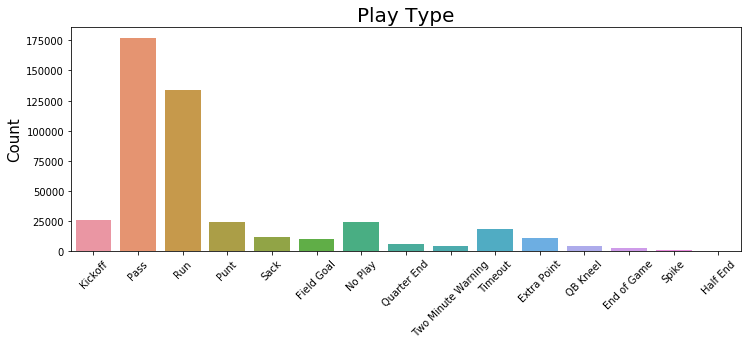

In [ ]:
# plot barchart of play types

plt.figure(figsize = (12,14))

plt.subplot(311)
g = sns.countplot(x="PlayType", data=nfl)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=15)
g.set_title("Play Type", fontsize=20)

#### Counts

In [ ]:
# get counts of play types
nfl['PlayType'].value_counts()

Pass                  177035
Run                   133742
Kickoff                26050
Punt                   24217
No Play                23893
Timeout                18098
Sack                   11944
Extra Point            11225
Field Goal              9874
Quarter End             5626
Two Minute Warning      4251
QB Kneel                3925
End of Game             2191
Spike                    718
Half End                  46
Name: PlayType, dtype: int64

#### Remove Bad Data

In [ ]:
# remove any play type that is 'No Play'
nfl = nfl[nfl['PlayType'] != 'No Play']

In [ ]:
# doulbe check counts
nfl['PlayType'].value_counts()

Pass                  177035
Run                   133742
Kickoff                26050
Punt                   24217
Timeout                18098
Sack                   11944
Extra Point            11225
Field Goal              9874
Quarter End             5626
Two Minute Warning      4251
QB Kneel                3925
End of Game             2191
Spike                    718
Half End                  46
Name: PlayType, dtype: int64

### Quarter

#### Plot

Text(0.5, 1.0, 'Quarter')

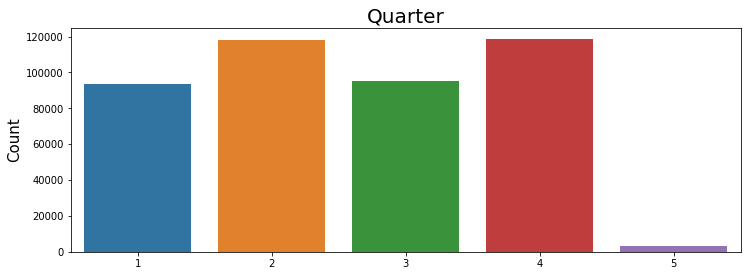

In [ ]:
# plot barchart of quarters

plt.figure(figsize = (12,14))

plt.subplot(311)
g = sns.countplot(x="qtr", data=nfl)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=15)
g.set_title("Quarter", fontsize=20)

#### Remove Bad Data

In [ ]:
# remove any quarter that is 5. We aren't going to predict overtime
nfl = nfl[nfl['qtr'] != 5]

In [ ]:
# double check counts
nfl['qtr'].value_counts()

4    118858
2    118003
3     95132
1     93834
Name: qtr, dtype: int64

### Downs

Text(0.5, 1.0, 'Down')

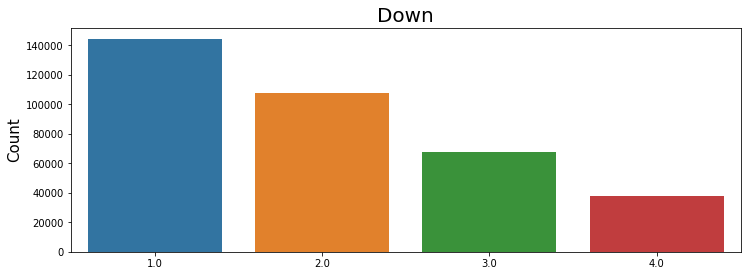

In [ ]:
# plot downs
plt.figure(figsize = (12,14))

plt.subplot(311)
g = sns.countplot(x="down", data=nfl)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=15)
g.set_title("Down", fontsize=20)

In [ ]:
# Check for NA
nfl['down'].isna().sum()

67772

In [ ]:
# remove NA for downs
nfl = nfl[np.isfinite(nfl['down'])]
nfl.isna().sum()


GameID                         0
date                           0
home                           0
away                           0
homescore                      0
awayscore                      0
ScoreDiff                      0
play_id                        0
Drive                          0
qtr                            0
down                           0
time                           0
TimeUnder                      0
TimeSecs                       0
PlayTimeDiff                  17
yrdln                          0
yrdline100                     0
ydstogo                        0
ydsnet                         0
GoalToGo                       0
FirstDown                      0
posteam                        0
DefensiveTeam                  0
desc                           0
PlayAttempted                  0
Yards.Gained                   0
sp                             0
Touchdown                      0
PlayType                       0
HomeTimeouts_Remaining_Pre     0
AwayTimeou

In [ ]:
# double check missing data in the whole dataframe

## Add Response Variable

In [ ]:
# add the winner of the game
nfl['winner'] = np.where(nfl['homescore'] > nfl['awayscore'], nfl['home'], nfl['away'])

In [ ]:
# add the variable that we will ultimately predict on. Name it 'poswin'
nfl['poswin'] = np.where(nfl['winner'] == nfl['posteam'], 'Win', 'Lose')

In [ ]:
# check data
nfl.head()

,GameID,date,home,away,homescore,awayscore,ScoreDiff,play_id,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,yrdln,yrdline100,ydstogo,ydsnet,GoalToGo,FirstDown,posteam,DefensiveTeam,desc,PlayAttempted,Yards.Gained,sp,Touchdown,PlayType,HomeTimeouts_Remaining_Pre,AwayTimeouts_Remaining_Pre,Season,winner,poswin
1,2009091000,2009-09-10,PIT,TEN,13,10,0.0,68,1,1,1.0,14:53,15,3593.0,7.0,42.0,58.0,10,5,0.0,0.0,PIT,TEN,(14:53) B.Roethlisberger pass short left to H....,1,5,0,0,Pass,3,3,2009,PIT,Win
2,2009091000,2009-09-10,PIT,TEN,13,10,0.0,92,1,1,2.0,14:16,15,3556.0,37.0,47.0,53.0,5,2,0.0,0.0,PIT,TEN,(14:16) W.Parker right end to PIT 44 for -3 ya...,1,-3,0,0,Run,3,3,2009,PIT,Win
3,2009091000,2009-09-10,PIT,TEN,13,10,0.0,113,1,1,3.0,13:35,14,3515.0,41.0,44.0,56.0,8,2,0.0,0.0,PIT,TEN,(13:35) (Shotgun) B.Roethlisberger pass incomp...,1,0,0,0,Pass,3,3,2009,PIT,Win
4,2009091000,2009-09-10,PIT,TEN,13,10,0.0,139,1,1,4.0,13:27,14,3507.0,8.0,44.0,56.0,8,2,0.0,1.0,PIT,TEN,(13:27) (Punt formation) D.Sepulveda punts 54 ...,1,0,0,0,Punt,3,3,2009,PIT,Win
5,2009091000,2009-09-10,PIT,TEN,13,10,0.0,162,2,1,1.0,13:16,14,3496.0,11.0,2.0,98.0,10,0,0.0,0.0,TEN,PIT,(13:16) C.Johnson up the middle to TEN 2 for n...,1,0,0,0,Run,3,3,2009,PIT,Lose


## Prep Data


This makes the win as the postive prediction in our classification model

**Variables to include**

*   Quarter
*   Down
*   Distance to first down
*   Position on the field
*   Time left in the game
*   Score Differential


### Split the X and Y sets

In [ ]:
#  get your x variables
var = ['qtr', 'down', 'ydstogo', 'yrdline100', 'TimeSecs', 'ScoreDiff']
X = nfl[var]

# get your y variable
y = nfl['poswin']

print(X.shape, y.shape)

(358055, 6) (358055,)


### Split Train and Test Datasets

We need to create a training and a test dataset. 80% of the data will be in the training set. 20% will be in the test set.

In [ ]:
# Split the data into a train and test dataset. 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# print the shape of the X_train and y_train datasets
print(X_train.shape, y_train.shape)

# print the shape of the X_test and y_test datasets
print(X_test.shape, y_test.shape)

(286444, 6) (286444,)
(71611, 6) (71611,)


# Logistic Model

In [ ]:
# 10 Fold Cross Validation. 
num_instances = len(X)
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = LogisticRegression()
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Accuracy: 74.385% (0.282%)


In [ ]:
model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predictions = model.predict_proba(X)

In [ ]:
LoseProb = predictions[:,0]
WinProb = predictions[:,1]


In [ ]:
nfl['WinProb'] = WinProb
nfl['LoseProb'] = LoseProb

In [ ]:
nfl.tail()

,GameID,date,home,away,homescore,awayscore,ScoreDiff,play_id,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,yrdln,yrdline100,ydstogo,ydsnet,GoalToGo,FirstDown,posteam,DefensiveTeam,desc,PlayAttempted,Yards.Gained,sp,Touchdown,PlayType,HomeTimeouts_Remaining_Pre,AwayTimeouts_Remaining_Pre,Season,winner,poswin,WinProb,LoseProb
452828,2018123011,2018-12-30,TEN,IND,17,33,-17.0,4219,23,4,1.0,02:08,3,128.0,9.0,24.0,76.0,20,-6,0.0,0.0,TEN,IND,(2:08) (Shotgun) B.Gabbert pass short left to ...,1,4,0,0,Pass,2,3,2018,IND,Lose,0.049936,0.950064
452830,2018123011,2018-12-30,TEN,IND,17,33,-17.0,4261,23,4,2.0,02:00,2,120.0,0.0,28.0,72.0,16,-6,0.0,1.0,TEN,IND,(2:00) (Shotgun) B.Gabbert pass short middle i...,1,0,0,0,Pass,2,3,2018,IND,Lose,0.048146,0.951854
452831,2018123011,2018-12-30,TEN,IND,17,33,17.0,4288,24,4,1.0,01:50,2,110.0,10.0,8.0,8.0,8,-3,1.0,0.0,IND,TEN,(1:50) A.Luck kneels to TEN 9 for -1 yards.,1,-1,0,0,QB Kneel,2,3,2018,IND,Win,0.976745,0.023255
452832,2018123011,2018-12-30,TEN,IND,17,33,17.0,4310,24,4,2.0,01:06,2,66.0,44.0,9.0,9.0,9,-3,1.0,0.0,IND,TEN,(1:06) A.Luck kneels to TEN 10 for -1 yards.,1,-1,0,0,QB Kneel,2,3,2018,IND,Win,0.973743,0.026257
452833,2018123011,2018-12-30,TEN,IND,17,33,17.0,4332,24,4,3.0,00:25,1,25.0,41.0,10.0,10.0,10,-3,1.0,0.0,IND,TEN,(:25) A.Luck kneels to TEN 11 for -1 yards.,1,-1,0,0,QB Kneel,2,3,2018,IND,Win,0.970373,0.029627


## Build Models

In [ ]:
# logistic regression
log_model = LogisticRegression()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


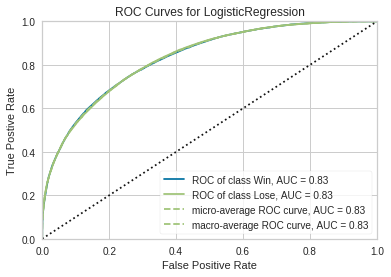

In [ ]:
# Set classes for all plots
classes = ['Win', 'Lose']
# Instantiate the visualizer with the classification model
visualizer = ROCAUC(log_model, classes=classes)


visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()   

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


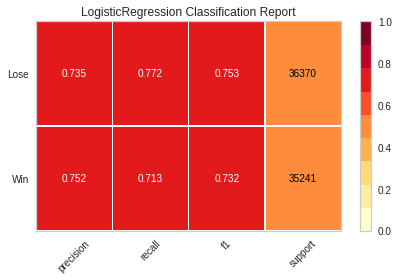


precision = proportion of returned results that are relevant
recall = proportion of relevant documents that are returned
f1-score = harmonic mean of precision and recall


In [ ]:
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(log_model, classes=classes, support=True)

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

print('\nprecision = proportion of returned results that are relevant')  
print('recall = proportion of relevant documents that are returned')   
print('f1-score = harmonic mean of precision and recall')

In [ ]:
predict_proba

# Plot One Game

New England vs Kansas City

Date = 2018-10-14

Final Score = 43 - 40

Game ID = 2018101412

In [ ]:
# filter to the game
kc_vs_ne = nfl[nfl['GameID'] == 2018101412]

In [ ]:
# add a home win probability and an away win probability column
kc_vs_ne['Home_WP'] = np.where(kc_vs_ne['poswin'] == 'Lose', 1-kc_vs_ne['WinProb'], kc_vs_ne['WinProb'])
kc_vs_ne['Away_WP'] = 1-kc_vs_ne['Home_WP']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
# view the last 10 plays in the game
kc_vs_ne.tail(10)

,GameID,date,home,away,homescore,awayscore,ScoreDiff,play_id,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,yrdln,yrdline100,ydstogo,ydsnet,GoalToGo,FirstDown,posteam,DefensiveTeam,desc,PlayAttempted,Yards.Gained,sp,Touchdown,PlayType,HomeTimeouts_Remaining_Pre,AwayTimeouts_Remaining_Pre,Season,winner,poswin,WinProb,LoseProb,Home_WP,Away_WP
424256,2018101412,2018-10-14,NE,KC,43,40,4.0,3716,21,4,3.0,03:25,4,205.0,0.0,32.0,32.0,5,47,0.0,0.0,NE,KC,(3:25) (Shotgun) T.Brady pass incomplete deep ...,1,0,0,0,Pass,3,1,2018,NE,Win,0.742277,0.257723,0.742277,0.257723
424257,2018101412,2018-10-14,NE,KC,43,40,4.0,3738,21,4,4.0,03:19,4,199.0,6.0,32.0,32.0,5,47,0.0,0.0,NE,KC,(3:19) S.Gostkowski 50 yard field goal is GOOD...,1,0,1,0,Field Goal,3,1,2018,NE,Win,0.721728,0.278272,0.721728,0.278272
424259,2018101412,2018-10-14,NE,KC,43,40,-7.0,3776,22,4,1.0,03:15,4,195.0,0.0,25.0,75.0,10,75,0.0,0.0,KC,NE,(3:15) P.Mahomes pass deep left to T.Hill for ...,1,75,1,1,Pass,3,1,2018,NE,Lose,0.251553,0.748447,0.748447,0.251553
424262,2018101412,2018-10-14,NE,KC,43,40,0.0,3827,23,4,1.0,03:03,4,183.0,0.0,25.0,75.0,10,65,0.0,0.0,NE,KC,(3:03) J.Edelman left end to NE 32 for 7 yards...,1,7,0,0,Run,3,1,2018,NE,Win,0.535592,0.464408,0.535592,0.464408
424263,2018101412,2018-10-14,NE,KC,43,40,0.0,3848,23,4,2.0,02:20,3,140.0,43.0,32.0,68.0,3,65,0.0,0.0,NE,KC,(2:20) S.Michel up the middle to NE 34 for 2 y...,1,2,0,0,Run,3,1,2018,NE,Win,0.537769,0.462231,0.537769,0.462231
424265,2018101412,2018-10-14,NE,KC,43,40,0.0,3886,23,4,3.0,02:00,2,120.0,0.0,34.0,66.0,1,65,0.0,1.0,NE,KC,(2:00) S.Michel left tackle to NE 36 for 2 yar...,1,2,0,0,Run,3,1,2018,NE,Win,0.519675,0.480325,0.519675,0.480325
424266,2018101412,2018-10-14,NE,KC,43,40,0.0,3907,23,4,1.0,01:29,2,89.0,31.0,36.0,64.0,10,65,0.0,1.0,NE,KC,(1:29) (Shotgun) T.Brady pass short left to J....,1,16,0,0,Pass,3,1,2018,NE,Win,0.557677,0.442323,0.557677,0.442323
424267,2018101412,2018-10-14,NE,KC,43,40,0.0,3931,23,4,1.0,00:51,1,51.0,38.0,48.0,48.0,10,65,0.0,0.0,NE,KC,(:51) (Shotgun) T.Brady pass deep right to R.G...,1,39,0,0,Pass,3,1,2018,NE,Win,0.591279,0.408721,0.591279,0.408721
424269,2018101412,2018-10-14,NE,KC,43,40,0.0,3976,23,4,1.0,00:17,1,17.0,0.0,9.0,9.0,9,65,1.0,0.0,NE,KC,(:17) T.Brady up the middle to KC 10 for -1 ya...,1,-1,0,0,Run,3,0,2018,NE,Win,0.671941,0.328059,0.671941,0.328059
424271,2018101412,2018-10-14,NE,KC,43,40,0.0,4018,23,4,2.0,00:03,1,3.0,0.0,10.0,10.0,10,65,1.0,0.0,NE,KC,"(:03) S.Gostkowski 28 yard field goal is GOOD,...",1,0,1,0,Field Goal,2,0,2018,NE,Win,0.644491,0.355509,0.644491,0.355509


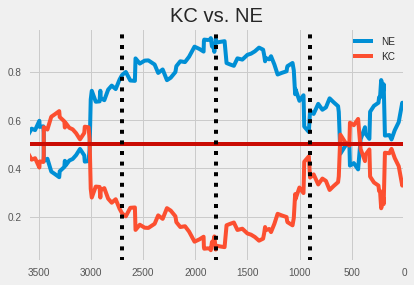

In [ ]:


plt.style.use('fivethirtyeight')


x = kc_vs_ne['TimeSecs']
y = kc_vs_ne['Home_WP']
y1 = kc_vs_ne['Away_WP']

fig, ax = plt.subplots()

plt.xlim(3600, 0)
ax.plot(x, y, label='NE')
ax.plot(x, y1, label='KC')
ax.set_title("KC vs. NE")

plt.axhline(y=0.5, color='r', linestyle='-')
plt.axvline(x=2700, color='black', linestyle=':')
plt.axvline(x=1800, color='black', linestyle=':')
plt.axvline(x=900, color='black', linestyle=':')

ax.legend()
plt.show()

# Naive Bayes Model

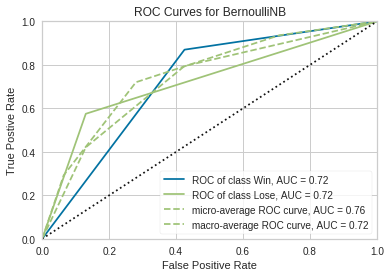

In [ ]:
# Naive Bayes Model
# prior is set to 50/50 for each class
class_prior = [0.5, 0.5] 
bayes = BernoulliNB(class_prior=class_prior)

# Set classes for all plots
classes = ['Win', 'Lose']
# Instantiate the visualizer with the classification model
visualizer = ROCAUC(bayes, classes=classes)


visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()   

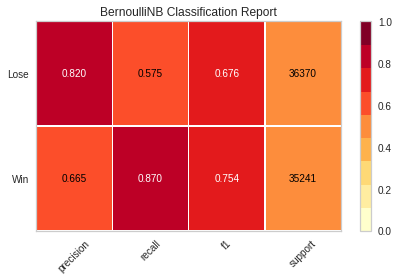


precision = proportion of returned results that are relevant
recall = proportion of relevant documents that are returned
f1-score = harmonic mean of precision and recall


In [ ]:
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(bayes, classes=classes, support=True)

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

print('\nprecision = proportion of returned results that are relevant')  
print('recall = proportion of relevant documents that are returned')   
print('f1-score = harmonic mean of precision and recall')

# Random Forest Model

In [ ]:
y_train

add_binary_df = pd.get_dummies(y_train, 
                               columns=['overage', 
                                        'domestic_import', 
                                        'vehicle_type',
                                        'color_set', 
                                        'makex'], 
                               prefix=['overage', 
                                       'mfg', 
                                       'body', 
                                       'color', 
                                       'make'])

449266     Win
60329      Win
288937     Win
368107    Lose
81984      Win
219969     Win
59340      Win
179041     Win
431864    Lose
362283    Lose
214313     Win
3555       Win
133594     Win
407668     Win
306450     Win
377755    Lose
372410     Win
300453    Lose
321532     Win
147200     Win
387415    Lose
191451     Win
415113    Lose
306658    Lose
293377    Lose
75678     Lose
308990     Win
365089    Lose
212853    Lose
113745    Lose
          ... 
228620    Lose
236220    Lose
452597    Lose
154784    Lose
15496     Lose
281796     Win
77673      Win
427281     Win
57082     Lose
116198    Lose
417338     Win
165006    Lose
208972    Lose
48925      Win
305106     Win
77780     Lose
157706    Lose
435928     Win
126416    Lose
257966    Lose
248768    Lose
428009    Lose
95879      Win
297364     Win
235304     Win
337842     Win
50818     Lose
114974     Win
442617     Win
352372     Win
Name: poswin, Length: 286444, dtype: object

In [ ]:
# Pretty print a confusion matrixes rows actual, columns predicted
# Adapted from: https://gist.github.com/zachguo/10296432
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, 
             hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.0f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [ ]:

# --------------------------------------------------------
# Assess elapsed time associated with the model fitting 
# ignoring input/output processing for the most part
start_time = time.clock()  # wall-clock time at beginning of modeling work

# define Study 5 classifier method as random forests 
clf = RandomForestClassifier(n_estimators=100, 
            criterion='gini', 
            max_depth=None, 
            min_samples_split=20, 
            min_samples_leaf=5, 
            min_weight_fraction_leaf=0.0, 
            max_features=6,
            max_leaf_nodes=None, 
            bootstrap=True, 
            oob_score=False, 
            n_jobs=1, 
            random_state=1234, 
            verbose=0, 
            warm_start=False, 
            class_weight=None) 

# Fit classifier to the data and evaluate its performance
# in terms of precision, recall, and F1-score

clf.fit(X_train, y_train) 
end_time = time.clock()  # wall-clock time at end of modeling work
runtime = end_time - start_time  # seconds of wall-clock time 
print('\nRandom forest classification elapsed time (seconds):', 
      np.round(runtime, decimals = 3))

print('\n---------------------------------------------------------------------------')
print('Random Forests Regression Model Explanatory Variable Importance Results')

var_importance = clf.feature_importances_
final_model_results = pd.DataFrame({'name': var,
                                    'importance': var_importance})
    
print(final_model_results)     


# Report results of random forest classifier
Result = ['Win', 'Lose'] 
y_final_test_predict = clf.predict(X_test)

print('\nRandom Forest Confusion Matrix (rows actual, columns predicted)\n')
print_cm(confusion_matrix(y_test, y_final_test_predict,
                 labels = Result)

print('\nRandom Forest Predictive Accuracy: ',                
np.round(accuracy_score(y_test.values.argmax(axis=1), 
               y_final_test_predict.argmax(axis=1)), decimals = 3))

print('\nSummary of Random Forest Precision and Recall\n') 
             
print(classification_report(y_test, y_final_test_predict, 
                            target_names = Result))

print('precision = proportion of returned results that are relevant')  
print('recall = proportion of relevant documents that are returned')   
print('f1-score = harmonic mean of precision and recall')


Random forest classification elapsed time (seconds): 126.26

---------------------------------------------------------------------------
Random Forests Regression Model Explanatory Variable Importance Results
         name  importance
0         qtr    0.001167
1        down    0.017120
2     ydstogo    0.051756
3  yrdline100    0.115417
4    TimeSecs    0.225409
5   ScoreDiff    0.589131

Random Forest Confusion Matrix (rows actual, columns predicted)



AxisError: ignored